<a href="https://colab.research.google.com/github/Heba2424/DEPI_Projects/blob/main/human_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supervisely-filtered-segmentation-person-dataset/df.csv
/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/collage/ds6_pexels-photo-792385.jpg
/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/collage/ds6_pexels-photo-797758.jpg
/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/collage/ds11_pexels-photo-866027.jpg
/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/collage/ds6_pexels-photo-226273.jpg
/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/collage/ds1_pexels-photo-340779.jpg
/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_i

In [ ]:
df = pd.read_csv('/kaggle/input/supervisely-filtered-segmentation-person-dataset/df.csv')

In [ ]:
df.head()

,Unnamed: 0,images,masks,collages
0,0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,collage/ds10_pexels-photo-687782.jpg
1,1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,collage/ds10_pexels-photo-835971.jpg
2,2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,collage/ds10_pexels-photo-850708.jpg
3,3,images/ds10_pexels-photo-864937.png,masks/ds10_pexels-photo-864937.png,collage/ds10_pexels-photo-864937.jpg
4,4,images/ds10_pexels-photo-865908.png,masks/ds10_pexels-photo-865908.png,collage/ds10_pexels-photo-865908.jpg


In [ ]:
df.drop(['collages'],axis=1, inplace=True)

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Load images and masks
def load_data(img_folder, mask_folder, img_size=(256, 256)):
    images = []
    masks = []

    img_files = sorted(os.listdir(img_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(img_files, mask_files):
        img_path = os.path.join(img_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        img = load_img(img_path, target_size=img_size, color_mode='grayscale')
        img = img_to_array(img) / 255.0

        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Paths to your dataset
img_folder = '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images'
mask_folder = '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks'

images, masks = load_data(img_folder, mask_folder)


2024-07-14 21:04:06.545954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 21:04:06.546132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 21:04:06.664850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize


def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.layers.Input(input_size)
    # Encoding path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoding path
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-5, clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


# Callbacks
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)

# Train the model
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

Epoch 1/50


2024-07-14 21:07:52.949428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 0.77322, expected 0.382457
2024-07-14 21:07:52.949484: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.23655, expected 0.845791
2024-07-14 21:07:52.949493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.18466, expected 0.793895
2024-07-14 21:07:52.949501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.90192, expected 1.51115
2024-07-14 21:07:52.949509: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.55551, expected 1.16474
2024-07-14 21:07:52.949516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.37661, expected 0.985849
2024-07-14 21:07:52.949524: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.02345, expected 1.63269
2024-07-14 21:07:52.949532: E external/local_xla/xl

133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6862 - loss: 0.6572

2024-07-14 21:09:41.310660: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.06306, expected 0.587185
2024-07-14 21:09:41.310731: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.37522, expected 1.89934
2024-07-14 21:09:41.310741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.49553, expected 2.01965
2024-07-14 21:09:41.310749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.35389, expected 1.87801
2024-07-14 21:09:41.310756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.81771, expected 2.34183
2024-07-14 21:09:41.310764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.83996, expected 2.36408
2024-07-14 21:09:41.310771: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.48233, expected 2.00645
2024-07-14 21:09:41.310784: E external/local_xla/xla/s

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6862 - loss: 0.6571

2024-07-14 21:10:12.878851: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.56128, expected 0.753217
2024-07-14 21:10:12.878907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.43313, expected 0.625073
2024-07-14 21:10:12.878916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.10298, expected 1.29493
2024-07-14 21:10:12.878924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.11037, expected 1.30231
2024-07-14 21:10:12.878932: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.69944, expected 0.891379
2024-07-14 21:10:12.878940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.31321, expected 1.50515
2024-07-14 21:10:12.878947: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.23039, expected 1.42233
2024-07-14 21:10:12.878955: E external/local_xla/xla


Epoch 1: val_loss improved from inf to 0.61840, saving model to model_for_nuclei.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 163s 678ms/step - accuracy: 0.6862 - loss: 0.6569 - val_accuracy: 0.6822 - val_loss: 0.6184
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6849 - loss: 0.6044
Epoch 2: val_loss improved from 0.61840 to 0.54068, saving model to model_for_nuclei.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6849 - loss: 0.6042 - val_accuracy: 0.7093 - val_loss: 0.5407
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7223 - loss: 0.5185
Epoch 3: val_loss improved from 0.54068 to 0.51790, saving model to model_for_nuclei.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7223 - loss: 0.5185 - val_accuracy: 0.7295 - val_loss: 0.5179
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7359 - loss: 0.4942
Epoch 4: val_loss improved from 0.51790 to 0.49108, saving model to model_for_nuclei.keras
134/134 ━━━━━━

In [ ]:
# Evaluate the model on validation set
model.evaluate(X_val, y_val)

2024-07-14 21:52:34.670594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 1.05936, expected 0.681349
2024-07-14 21:52:34.670656: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.21753, expected 1.83952
2024-07-14 21:52:34.670672: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.5462, expected 2.16819
2024-07-14 21:52:34.670690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.07291, expected 1.6949
2024-07-14 21:52:34.670702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.56529, expected 2.18728
2024-07-14 21:52:34.670712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.19261, expected 1.8146
2024-07-14 21:52:34.670738: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 1.83463, expected 1.45662
2024-07-14 21:52:34.670750: E

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7999 - loss: 0.4203

2024-07-14 21:53:24.624604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 0.882102, expected 0.484618
2024-07-14 21:53:24.624661: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.56227, expected 1.16479
2024-07-14 21:53:24.624670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.77135, expected 1.37387
2024-07-14 21:53:24.624678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.69872, expected 1.30124
2024-07-14 21:53:24.624686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.85432, expected 1.45684
2024-07-14 21:53:24.624694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.00845, expected 1.61097
2024-07-14 21:53:24.624701: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.78631, expected 1.38883
2024-07-14 21:53:24.624709: E external/local_xla/xla/

17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7988 - loss: 0.4253


[0.4654823839664459, 0.7903406023979187]

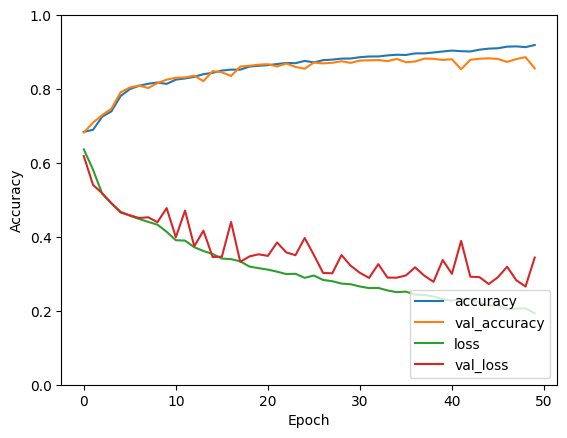

In [ ]:

# Plot training history
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
